In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
    data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
    data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
                       "EM_recall":"R [{}]".format(mode),
                       "EM_jaccard":"J [{}]".format(mode),})
    df = df.merge(data)

In [5]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

Extracting important clusters only

- J [GTLSA] is doing very badly

In [26]:
metric_J= [u'J [MV]', u'J [GT]', u'J [isoGT]', u'J [GTLSA]', u'J [isoGTLSA]', u'J [basic]']
df["J [avrg]"]=df[metric_J].mean(axis=1)

filtered_algo_df = df[df["clust"].isin([0,-1])]

best_thres_clust = df.loc[df.groupby(['num_workers','sample_num','objid'])["J [avrg]"].idxmax()]

In [21]:
best_thres_clust.mean()[metric_keys]

P [MV]          0.946936
R [MV]          0.928896
J [MV]          0.882213
P [GT]          0.928893
R [GT]          0.969624
J [GT]          0.902690
P [isoGT]       0.961257
R [isoGT]       0.939234
J [isoGT]       0.904701
P [GTLSA]       0.964222
R [GTLSA]       0.930962
J [GTLSA]       0.900042
P [isoGTLSA]    0.967448
R [isoGTLSA]    0.932737
J [isoGTLSA]    0.904457
P [basic]       0.953215
R [basic]       0.948447
J [basic]       0.906506
dtype: float64

### Performance as it varies with number of workers

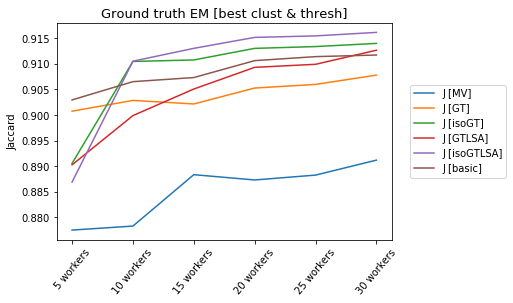

In [27]:
Nworker_performance = best_thres_clust.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
#    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

In [28]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [33]:
from glob import glob 
import pandas as pd

globfnames = glob("withClust_greedy_result_*.csv")
globfnames.remove('withClust_greedy_result_worker_fraction.csv')
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

# assert len(greedy_df)==31*44*5

greedy_df.to_csv("withClust_all_greedy_result.csv")

In [87]:
greedy_df = pd.read_csv("withClust_all_greedy_result.csv",index_col=0)

ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
ground_truth_greedy_df["cluster_id"]=-1
greedy_df = greedy_df.append(ground_truth_greedy_df)

worker_frac_greedy_df = pd.read_csv("withClust_greedy_result_worker_fraction.csv")
greedy_df = greedy_df.append(worker_frac_greedy_df)

greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

In [98]:
noClust_greedy = pd.read_csv("greedy_old_results/all_greedy_result.csv",index_col=0)
noClust_greedy["cluster_id"]=-1
noClust_greedy["num_workers"] = noClust_greedy["sample"].apply(lambda x: int(x.split("workers")[0]))
greedy_df = pd.concat([greedy_df,noClust_greedy])

In [99]:
greedy_df.head()

,algo,cluster_id,j,num_workers,objid,p,r,sample
0,basic,0,0.968438,15,1,0.990708,0.977314,15workers_rand3
1,GT,0,0.970888,15,1,0.983373,0.987091,15workers_rand3
2,isoGT,0,0.973283,15,1,0.987896,0.985029,15workers_rand3
3,GTLSA,0,0.959324,15,1,0.996167,0.962878,15workers_rand3
4,isoGTLSA,0,0.973527,15,1,0.990077,0.983119,15workers_rand3


In [110]:
greedy_df.groupby(['sample','objid','cluster_id','algo']).mean()

j  num_workers  \
sample          objid cluster_id algo                                     
10workers_rand0 1     -1         GT               0.970089           10   
                                 GTLSA            0.955264           10   
                                 basic            0.969673           10   
                                 ground truth     0.993338           10   
                                 isoGT            0.972730           10   
                                 isoGTLSA         0.973009           10   
                       0         GT               0.970089           10   
                                 GTLSA            0.955264           10   
                                 basic            0.969673           10   
                                 isoGT            0.972730           10   
                                 isoGTLSA         0.973009           10   
                                 worker fraction  0.970041           10   
                       1         GT               0.970089           10   
                                 GTLSA            0.955264           10   
                                 basic            0.969673           10   
                                 isoGT            0.972730           10   
                                 isoGTLSA         0.973009           10   
                                 worker fraction  0.186644           10   
                2     -1         GT               0.938077           10   
                                 GTLSA            0.948598           10   
                                 basic            0.942380           10   
                                 ground truth     0.976943           10   
                                 isoGT            0.948598           10   
                                 isoGTLSA         0.948598           10   
                3     -1         GT               0.894634           10   
                                 GTLSA            0.875855           10   
                                 basic            0.886306           10   
                                 ground truth     0.959609           10   
                                 isoGT            0.896855           10   
                                 isoGTLSA         0.898198           10   
...                                                    ...          ...   
5workers_rand9  46    -1         GT               0.888633            5   
                                 GTLSA            0.882851            5   
                                 basic            0.895982            5   
                                 ground truth     0.944482            5   
                                 isoGT            0.891796            5   
                                 isoGTLSA         0.899314            5   
                47    -1         GT               0.858203            5   
                                 GTLSA            0.858245            5   
                                 basic            0.852623            5   
                                 ground truth     0.930033            5   
                                 isoGT            0.858245            5   
                                 isoGTLSA         0.858245            5   
                       0         GT               0.858203            5   
                                 GTLSA            0.858245            5   
                                 basic            0.852623            5   
                                 isoGT            0.858245            5   
                                 isoGTLSA         0.858245            5   
                                 worker fraction  0.864081            5   
                       1         GT               0.858203            5   
                                 GTLSA            0.858245            5   
                                 basic            0.852623            5   
       

In [106]:
best_thres_clust = greedy_df.loc[greedy_df.groupby(['sample','objid','cluster_id','algo'])["j"].idxmax()]

In [109]:
best_thres_clust

,algo,cluster_id,j,num_workers,objid,p,r,sample
1,GT,0,0.970888,15,1,0.983373,0.987091,15workers_rand3
1,GT,0,0.965796,5,1,0.979579,0.985640,5workers_rand7
1,GT,0,0.966021,20,1,0.975324,0.990223,20workers_rand3
1,GT,0,0.956198,5,1,0.965893,0.989612,5workers_rand2
1,GT,0,0.963341,15,1,0.974218,0.988543,15workers_rand5
1,GT,0,0.969640,10,1,0.977599,0.991674,10workers_rand4
1,GT,0,0.962716,15,1,0.970195,0.992056,15workers_rand1
1,GT,0,0.963589,10,1,0.972587,0.990490,10workers_rand5
1,GT,0,0.960840,10,1,0.969786,0.990490,10workers_rand2
1,GT,0,0.963552,5,1,0.974545,0.988428,5workers_rand1


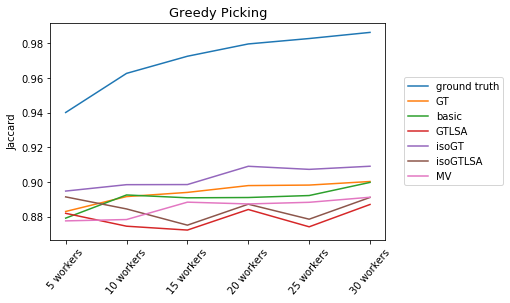

In [108]:
Nworker_performance = best_thres_clust.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    if algo!="worker fraction":
        plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [78]:
Nworker_performance = noClust_greedy.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


KeyError: 'num_workers'

In [19]:
greedy_df[(greedy_df["sample"]=="30workers_rand0")&(greedy_df["objid"]==7)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
31,30workers_rand0,7,GT,0.883962,0.949055,0.843917,30
32,30workers_rand0,7,isoGT,0.936327,0.932369,0.876778,30
33,30workers_rand0,7,GTLSA,0.928919,0.848943,0.797159,30
34,30workers_rand0,7,isoGTLSA,0.943166,0.930367,0.880977,30
1018,30workers_rand0,7,ground truth,0.986317,0.978198,0.965101,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30


This is interesting, the object performed badly with basic and worker fraction but advacned methods resolved this

In [54]:
greedy_df[(greedy_df["j"]<0.7)&(greedy_df["num_workers"]==30)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
138,30workers_rand0,28,GTLSA,0.256703,0.955701,0.253684,30
139,30workers_rand0,28,isoGTLSA,0.257111,0.963182,0.254608,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30
1026,30workers_rand0,15,worker fraction,0.681879,1.000000,0.681879,30


# Picking out poorly performing objects from Greedy EM 

Things that fail with GTLSA 

In [22]:
df["J [GTLSA-MV]"]=df["J [GTLSA]"]-df["J [MV]"]
df["J [GTLSA-MV]"] = df["J [GTLSA-MV]"].abs()

In [37]:
df[(df["num_workers"]>20)&(df["J [GTLSA-MV]"]>0.5)].head()

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832


It seems like for this case the GTLSA is failing because of some thresholds 

In [40]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==3)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6173,30,0,3,0.962144,0.914391,0.882636,2,0.934447,0.954569,0.894659,...,0.977740,0.899685,0.881626,0.971706,0.919905,0.895908,0.962207,0.915966,0.884157,0.001010
6174,30,0,3,0.962144,0.914391,0.882636,4,0.939425,0.952994,0.897823,...,0.978516,0.897059,0.879732,0.972920,0.915179,0.892446,0.962176,0.915179,0.883397,0.002904


In [41]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==4)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832
6177,30,0,4,0.944882,0.945455,0.896037,0,0.914845,0.976667,0.895278,...,0.010195,0.934848,0.010188,0.943520,0.961818,0.909456,0.945048,0.948485,0.898909,0.885849
6178,30,0,4,0.944882,0.945455,0.896037,2,0.916927,0.976667,0.897272,...,0.963636,0.931515,0.899883,0.946707,0.958182,0.909143,0.945015,0.947879,0.898334,0.003846
6179,30,0,4,0.944882,0.945455,0.896037,4,0.916856,0.975758,0.896437,...,0.966214,0.927273,0.898151,0.951705,0.955455,0.911272,0.946412,0.947273,0.899051,0.002114


same with this one

# What is the performance if we only pick easy objects? 

In [76]:
# Task difficulty
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region


small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]
all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

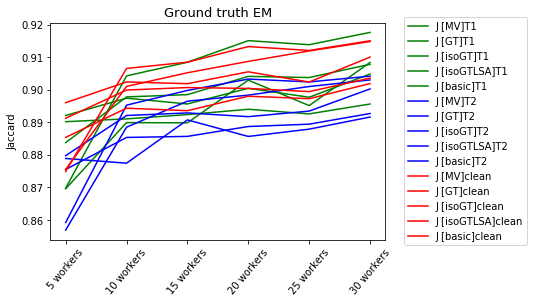

In [81]:
Nworker_performance = df[~df["objid"].isin(type_one_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T1",color="green")
        

Nworker_performance = df[~df["objid"].isin(type_two_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T2",color="blue")
        
Nworker_performance = df[df["objid"].isin(easy_tasks)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"clean",color="red")

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

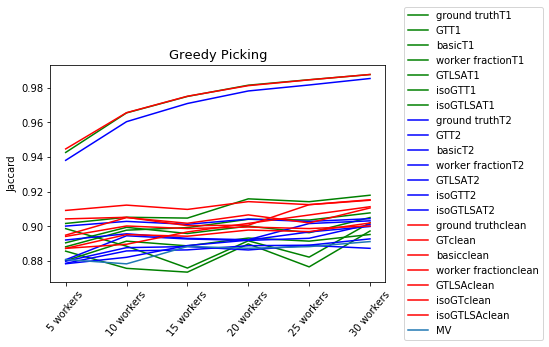

In [80]:
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_one_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T1",color="green")
#
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_two_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T2",color="blue")
#
Nworker_performance = greedy_df[greedy_df["objid"].isin(easy_tasks)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"clean",color="red")
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [73]:
len(easy_tasks)

41

In [74]:
len(object_lst)

44